In [1]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.2.0-rc3


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/KeithGalli/sklearn/master/data/sentiment/Books_small_10000.json \
    -O /tmp/reviews.json

embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .9


with open("/tmp/reviews.json", 'r') as f:
  sentences = []
  labels = []
  for line in f:
    item = json.loads(line)
    # Remove punctuation
    sentence = item['reviewText']
    sentence = sentence.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    sentence = sentence.lower()
    sentences.append(sentence)
    labels.append(int(item['overall'] >= 2.5))

print(len(sentences))

training_size = int(training_portion * len(sentences))
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;



--2020-05-02 09:34:08--  https://raw.githubusercontent.com/KeithGalli/sklearn/master/data/sentiment/Books_small_10000.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8063542 (7.7M) [text/plain]
Saving to: ‘/tmp/reviews.json’

/tmp/reviews.json   100%[===================>]   7.69M  28.3MB/s    in 0.3s    

2020-05-02 09:34:08 (28.3 MB/s) - ‘/tmp/reviews.json’ saved [8063542/8063542]

10000
32577
--2020-05-02 09:34:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (3

In [3]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          3257800   
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [4]:
num_epochs = 30
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(
  training_padded,
  training_labels,
  epochs=num_epochs,
  validation_data=(testing_padded, testing_labels),
  verbose=1)


Epoch 1/30
282/282 [==============================] - 2s 7ms/step - loss: 0.2636 - accuracy: 0.9330 - val_loss: 0.2341 - val_accuracy: 0.9420
Epoch 2/30
282/282 [==============================] - 2s 5ms/step - loss: 0.2411 - accuracy: 0.9349 - val_loss: 0.2342 - val_accuracy: 0.9420
Epoch 3/30
282/282 [==============================] - 2s 6ms/step - loss: 0.2410 - accuracy: 0.9349 - val_loss: 0.2336 - val_accuracy: 0.9420
Epoch 4/30
282/282 [==============================] - 2s 5ms/step - loss: 0.2395 - accuracy: 0.9349 - val_loss: 0.2321 - val_accuracy: 0.9420
Epoch 5/30
282/282 [==============================] - 2s 6ms/step - loss: 0.2371 - accuracy: 0.9349 - val_loss: 0.2310 - val_accuracy: 0.9420
Epoch 6/30
282/282 [==============================] - 2s 5ms/step - loss: 0.2340 - accuracy: 0.9349 - val_loss: 0.2323 - val_accuracy: 0.9420
Epoch 7/30
282/282 [==============================] - 2s 5ms/step - loss: 0.2311 - accuracy: 0.9349 - val_loss: 0.2382 - val_accuracy: 0.9420
Epoch 

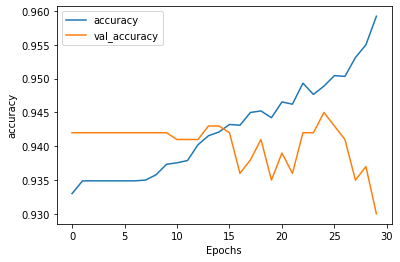

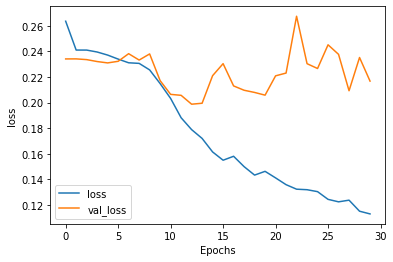

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [12]:
new_reviews = ["This book was very easy to read. I really enjoyed it.", "This book is too trivial and boring","I am sure this book is chalk full of good info! However it is certainly not a beginners book to investing. If you're like me and have no idea what the definition of terms like 'net tangible assets', and 'sub working capital' are it may be best to find a true beginners book as a prequel to this one. Lots of good info I cant yet understand."]
new_reviews_stripped = []
for review in new_reviews:
  # Remove punctuation
  review = review.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
  review = review.lower()
  new_reviews_stripped.append(review)
new_reviews_numeric = tokenizer.texts_to_sequences(new_reviews_stripped)
new_reviews_padded = pad_sequences(new_reviews_numeric, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(new_reviews_padded);
print(predictions)

[[0.9920616 ]
 [0.22662608]
 [0.8497924 ]]


In [0]:
with open( 'word_index.json' , 'w' ) as file:    
    json.dump( tokenizer.word_index , file )
model.save("amazon_reviews_sentiment.h5")

In [8]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 92kB 7.4MB/s 
     |████████████████████████████████| 104.6MB 116kB/s 
     |████████████████████████████████| 3.9MB 41.1MB/s 
     |████████████████████████████████| 450kB 52.6MB/s 
     |████████████████████████████████| 256kB 57.5MB/s 
     |████████████████████████████████| 921kB 51.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3748fe830036e1cf5d2539eca7a0b5af40923931603408eeb998820e276bc032
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=e49269f37e7913d7cdc0fb8870d7645686ec9e7ec7762a1dd075fb30e1c2d674
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built gast PyInquirer
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, b

In [9]:
import tensorflowjs as tfjs
!tensorflowjs_converter --input_format=keras_saved_model amazon_reviews_sentiment.h5 model/
# tfjs.converters.save_keras_model(model, 'model')
!zip -r /content/model.zip model/

2020-05-02 09:36:01.568382: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-05-02 09:36:01.572505: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-05-02 09:36:01.572686: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d18840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-02 09:36:01.572716: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-02 09:36:02.233376: W tensorflow/c/c_api.cc:326] Operation '{name:'lstm/while' id:270 op device:{} def:{{{node lstm/while}} = While[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_FLOAT, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _lower_using_switch_merge=true, _num_original_output